In [1]:
import pandas as pd
import seaborn as sns
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, brier_score_loss
from sklearn.calibration import calibration_curve
from itertools import combinations

In [2]:
with open("../config/endpoints.yaml", "r", encoding="UTF-8") as infile:
    endpoint_list = yaml.safe_load(infile)["endpoint"]

In [3]:
repo_base_path = Path(".").resolve().parents[0]

In [4]:
processed_endpoint_list = []
prediction_folder = repo_base_path / "data" / "intermediate_data" / "model_predictions"
for endpoint in endpoint_list:
    endpoint_result_file = prediction_folder / f"neural_fingerprint_predictions_{endpoint}.tsv.gz"
    if endpoint_result_file.exists():
        processed_endpoint_list.append(endpoint)

In [5]:
processed_endpoint_list

['APR_HepG2_CellLoss_72h_dn',
 'ATG_NRF2_ARE_CIS_up',
 'ATG_PXRE_CIS_up',
 'BSK_3C_HLADR_down',
 'BSK_3C_Proliferation_down',
 'BSK_3C_SRB_down',
 'BSK_3C_Vis_down',
 'BSK_4H_Eotaxin3_down',
 'BSK_CASM3C_Proliferation_down',
 'BSK_LPS_VCAM1_down',
 'BSK_SAg_CD38_down',
 'BSK_SAg_CD40_down',
 'BSK_SAg_Proliferation_down',
 'BSK_hDFCGF_CollagenIII_down',
 'BSK_hDFCGF_Proliferation_down']

In [87]:
analyzed_endpoint = processed_endpoint_list[3]

In [130]:
endpoint_neural_prediction_df = pd.read_csv(
    prediction_folder / f"neural_fingerprint_predictions_{analyzed_endpoint}.tsv.gz",
    sep="\t"
)
endpoint_neural_prediction_df["encoding"] = "Neural FP"

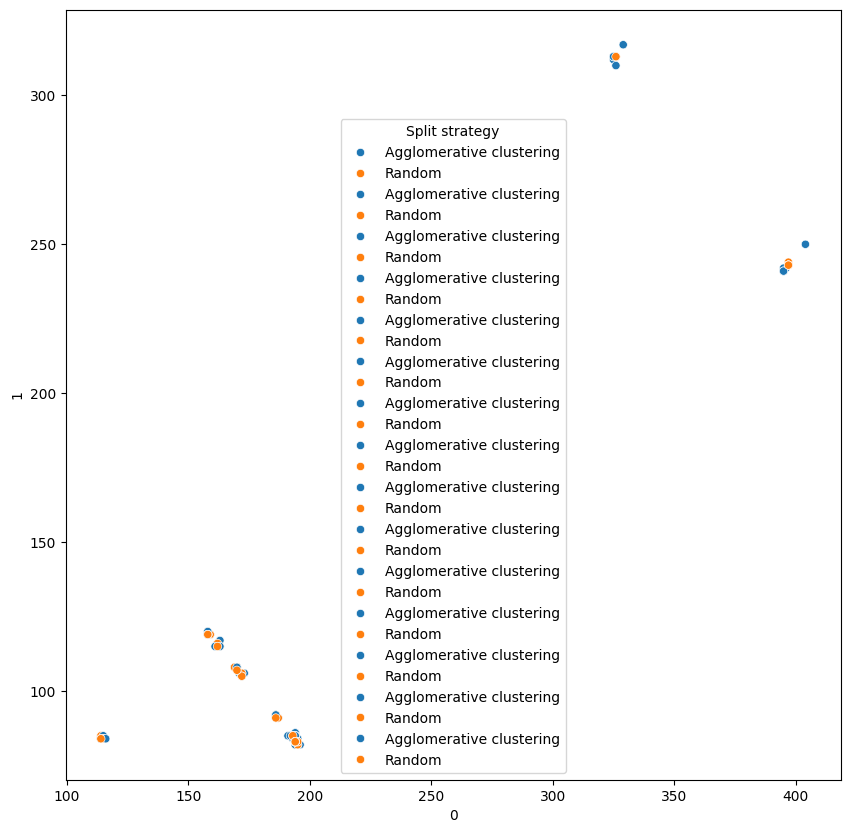

In [142]:
fig, ax = plt.subplots(figsize=(10,10))
for i, endpoint in enumerate(processed_endpoint_list):
    endpoint_df = pd.read_csv(
        prediction_folder / f"neural_fingerprint_predictions_{endpoint}.tsv.gz",
        sep="\t"
    )
    count_df = endpoint_df.pivot_table(index=["trial", "Split strategy"], values="smiles", columns="label", aggfunc="nunique")
    count_df.reset_index(inplace=True)
    sns.scatterplot(data=count_df, x=0, y=1, hue="Split strategy", ax=ax)

In [123]:
count_df

label,trial,Split strategy,0,1
0,0,Agglomerative clustering,171,106
1,0,Random,172,106
2,1,Agglomerative clustering,173,106
3,1,Random,172,106
4,2,Agglomerative clustering,173,106
5,2,Random,172,106
6,3,Agglomerative clustering,171,106
7,3,Random,172,106
8,4,Agglomerative clustering,172,105
9,4,Random,172,105


In [89]:
endpoint_morgan_prediction_df = pd.read_csv(
    prediction_folder / f"test_set_predictions_{analyzed_endpoint}.tsv.gz",
    sep="\t",
)
endpoint_morgan_prediction_df["encoding"] = "Morgan FP"

In [90]:
for (endpoint, model, split_method, trial), iter_df in endpoint_neural_prediction_df.groupby(["endpoint", "model", "Split strategy", "trial"]):
    smiles_set = set(iter_df["smiles"].tolist())
    morgan_iter_df = endpoint_morgan_prediction_df.query("endpoint==@endpoint & model==@model & `Split strategy`==@split_method & trial==@trial")
    morang_smiles_set = set(morgan_iter_df["smiles"].tolist())
    if smiles_set != morang_smiles_set:
        if model == "Chemprop":
            print(endpoint, model, split_method, trial)
        else:
            raise ValueError(endpoint, model, split_method, trial)

BSK_3C_HLADR_down Chemprop Agglomerative clustering 0
BSK_3C_HLADR_down Chemprop Agglomerative clustering 1
BSK_3C_HLADR_down Chemprop Agglomerative clustering 2
BSK_3C_HLADR_down Chemprop Agglomerative clustering 3
BSK_3C_HLADR_down Chemprop Agglomerative clustering 4
BSK_3C_HLADR_down Chemprop Random 0
BSK_3C_HLADR_down Chemprop Random 1
BSK_3C_HLADR_down Chemprop Random 2
BSK_3C_HLADR_down Chemprop Random 3
BSK_3C_HLADR_down Chemprop Random 4


In [91]:
endpoint_prediction_df = pd.concat([endpoint_neural_prediction_df, endpoint_morgan_prediction_df])

In [92]:
endpoint_prediction_df["Model name"] = endpoint_prediction_df[["encoding", "model"]].apply(" + ".join, axis=1)

In [93]:
endpoint_prediction_df.loc[endpoint_prediction_df["model"] == "Chemprop", "Model name"] = "Chemprop"

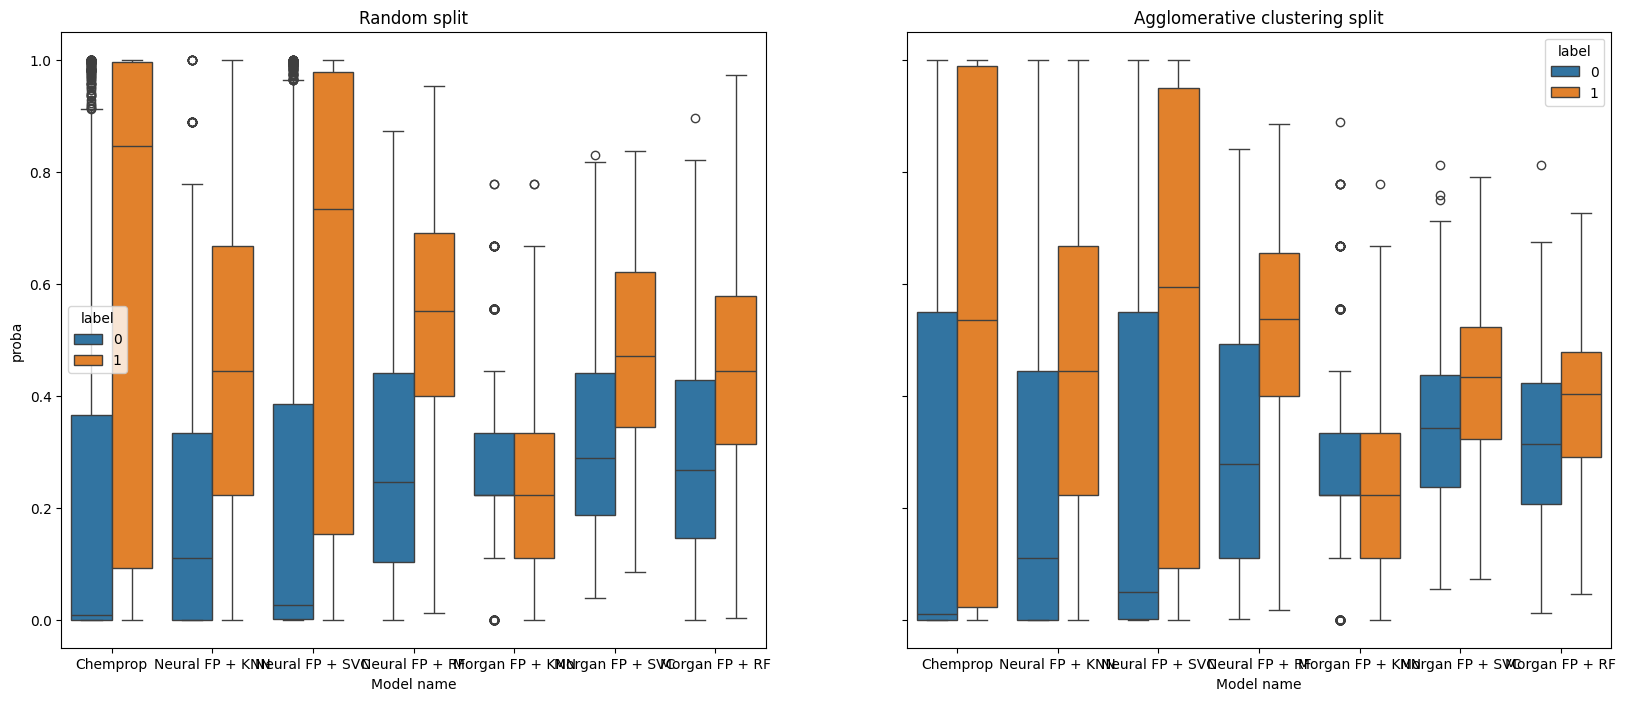

In [94]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2, sharey=True)
sns.boxplot(data=endpoint_prediction_df.query("`Split strategy` == 'Random'"), x="Model name", hue="label", y="proba", ax=axs[0])
sns.boxplot(data=endpoint_prediction_df.query("`Split strategy` == 'Agglomerative clustering'"), x="Model name", hue="label", y="proba", ax=axs[1])
axs[0].set_title("Random split")
axs[1].set_title("Agglomerative clustering split");

In [95]:
performance_df = []
for (model, trial, split), iter_df in endpoint_prediction_df.groupby(["Model name", "trial", "Split strategy"]):
    iter_dict = {
        "model": model,
        "trial": trial,
        "split": split,
    }
    ba_dict = {"metric": "BA", "Performance": balanced_accuracy_score(iter_df["label"], iter_df["prediction"])}
    brier_dict = {"metric": "Brier score", "Performance": brier_score_loss(iter_df["label"], iter_df["proba"])}
    for perf_dict in [ba_dict, brier_dict]:
        perf_dict.update(iter_dict)
        performance_df.append(perf_dict)
performance_df = pd.DataFrame(performance_df)

In [96]:
model_order = [
    'Morgan FP + KNN',
    'Neural FP + KNN',
    'Morgan FP + RF',
    'Neural FP + RF',
    'Morgan FP + SVC',
    'Neural FP + SVC',
    "Chemprop",
]
model_color = {m: c for m, c in zip(model_order, sns.color_palette("Paired"))}

/tmp/ipykernel_68223/2485111919.py:2: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.boxplot(data=performance_df.query("split == 'Random'"), x="metric", hue="model", y="Performance", ax=axs[0], palette=sns.color_palette("Paired"), hue_order=model_order)
/tmp/ipykernel_68223/2485111919.py:3: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.boxplot(data=performance_df.query("split == 'Agglomerative clustering'"), x="metric", hue="model", y="Performance", ax=axs[1], palette=sns.color_palette("Paired"), hue_order=model_order)


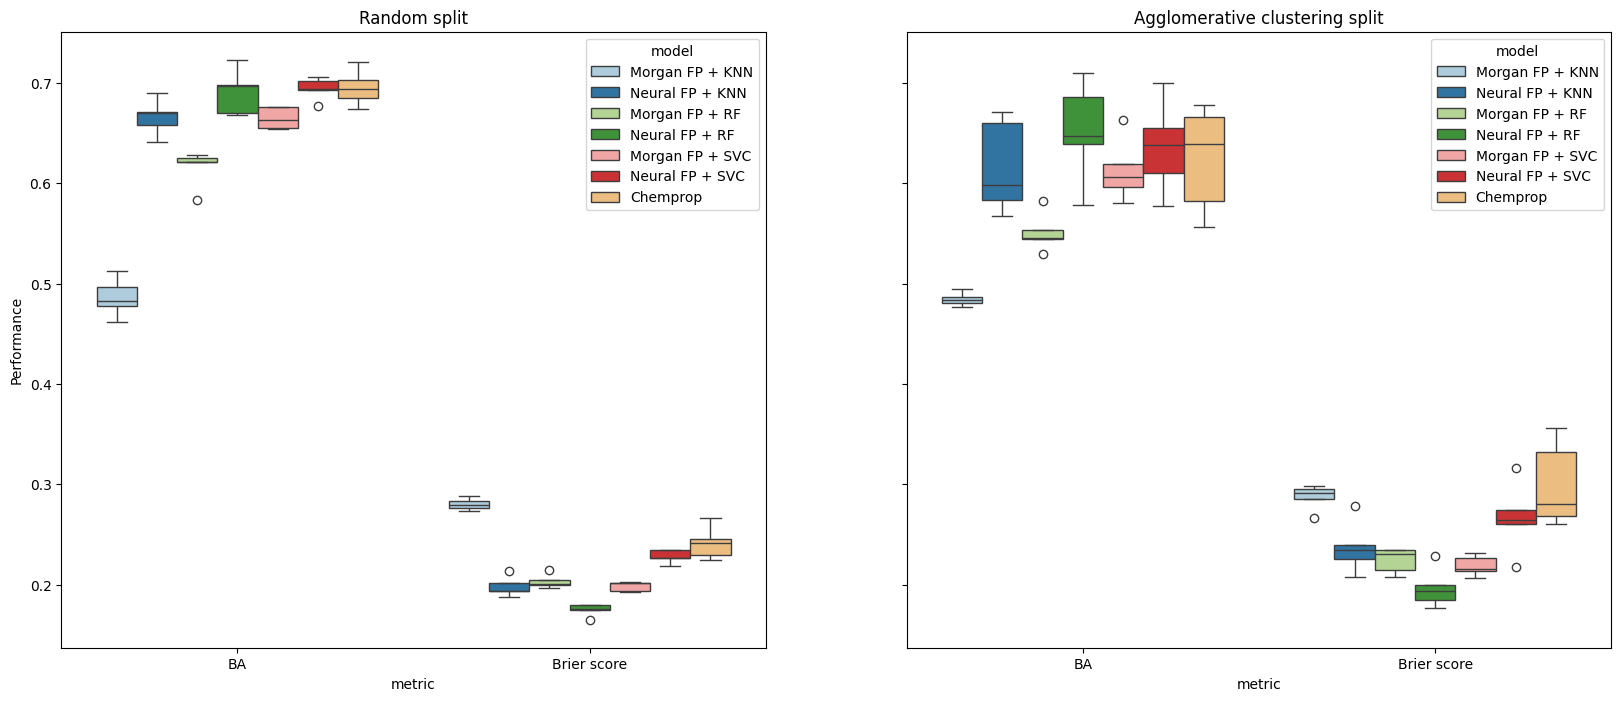

In [97]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2, sharey=True)
sns.boxplot(data=performance_df.query("split == 'Random'"), x="metric", hue="model", y="Performance", ax=axs[0], palette=sns.color_palette("Paired"), hue_order=model_order)
sns.boxplot(data=performance_df.query("split == 'Agglomerative clustering'"), x="metric", hue="model", y="Performance", ax=axs[1], palette=sns.color_palette("Paired"), hue_order=model_order)
axs[0].set_title("Random split")
axs[1].set_title("Agglomerative clustering split");

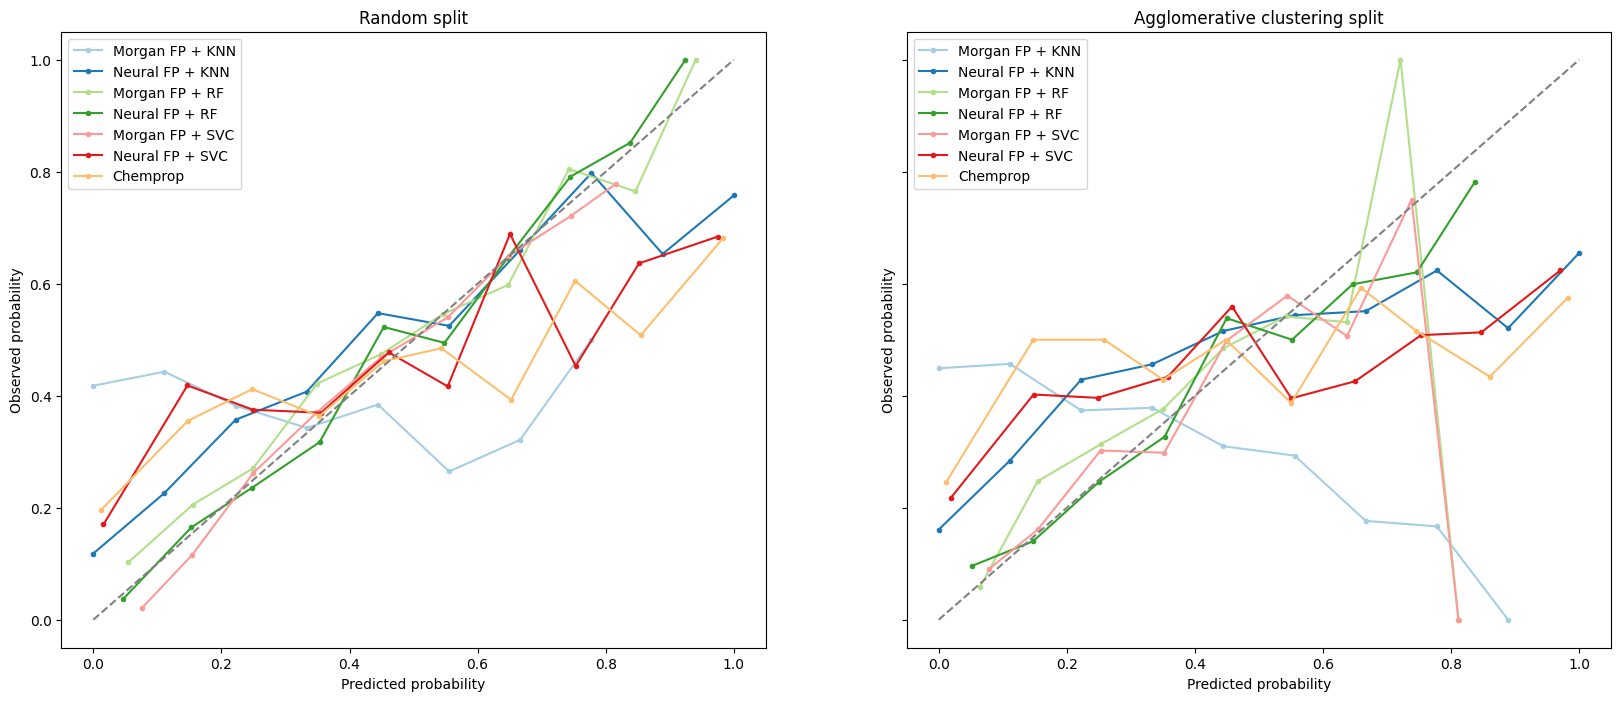

In [98]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2, sharey=True)
name2ax_dict = {"Random": 0, "Agglomerative clustering": 1}
for model, color in model_color.items():
    for split in endpoint_prediction_df["Split strategy"].unique():
        iter_df = endpoint_prediction_df.query("`Model name`==@model & `Split strategy` == @split")
        prob_true, prob_pred = calibration_curve(iter_df["label"], iter_df["proba"], n_bins=10)
        ax = axs[name2ax_dict[split]]
        ax.plot(prob_pred, prob_true, label=model, marker=".", color=color)
axs[0].plot((0,1), (0,1), ls="--", color="gray")
axs[1].plot((0,1), (0,1), ls="--", color="gray")
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("Predicted probability")
axs[1].set_xlabel("Predicted probability")
axs[0].set_ylabel("Observed probability")
axs[1].set_ylabel("Observed probability")
axs[0].set_title("Random split")
axs[1].set_title("Agglomerative clustering split");